In [1]:
%matplotlib inline

import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

def play_sound(x, amp=0.5):

    p = pyaudio.PyAudio()
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively) 
    stream.write(amp*x)
    stream.stop_stream()
    stream.close()
    p.terminate()
    pass


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx


def make_sound(f, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    x = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    return x


def make_AM_sound(f, amp_modulator, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    x = make_sound(f, fs, duration)
    x = np.multiply(x, amp_modulator)
    return x


def make_FM_sound(f, freq_modulator, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    fs = float(fs)
    x = (np.sin(2*np.pi*np.arange(fs*duration)*np.multiply(f/fs, freq_modulator))).astype(np.float32)
    return x


def complex_tone(freqs, amps, duration):
   # make tone
    tones = list()
    for amp, f in zip(amps, freqs):
        tones.append(make_sound(f, fs=fs, duration=duration)*amp)
    tone = np.array(tones).sum(0)  # sum the frequencies together
    return tone


def power_to_db(power, conversion_val=10):
    '''
    This is the conversion from power -> dB, as taken from a stack exchange forum.
    '''
    return conversion_val*np.log10(power)


def db_to_power(db, conversion_val=10):
    '''
    This is the conversion from dB -> power, as also taken from a stack exchange forum.
    '''
    return 10 ** (db/conversion_val)


def get_fft_half(tone, fs):
    power = np.abs(np.fft.fft(tone))
    n = len(power)
    freq = np.fft.fftfreq(n, 1/float(fs))

    # just get first half of spectrum
    half_n = int(np.ceil(n/2.0))
#     power = (2.0 / n) * power[:half_n]
    power = power[:half_n]
    freq_half = freq[:half_n]
    return power, freq_half


def get_db(tone, fs):

    N = 8192  # not sure where this comes from ... :/
    win = np.hamming(N)                                                       
    x = tone[0:N] * win                             # Take a slice and multiply by a window

    sp = np.fft.rfft(x)                               # Calculate real FFT (this just means the first half)

    mag = np.abs(sp) 
    ref = np.sum(win) / 2                             # Reference : window sum and factor of 2
                                                      # because we are using half of FFT spectrum

    s_dbfs = 20 * np.log10(mag / ref)                 # Convert to dBFS
    
    freq = np.fft.fftfreq(N, 1/float(fs))
    half_n = int(np.ceil(N/2.0))  # not sure about N
    freq_half = freq[:half_n+1]
    
    return s_dbfs, freq_half


def plot_wave_and_fft(tone, fs, t_max, freq_max, power_max):
    # plot waveform
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(tone)
    axs[0].set_xlim([0, t_max])
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Amplitude')

    # get fft
    power, freq_half = get_fft_half(tone, fs)

    # plot fft
    axs[1].plot(freq_half, power, lw=4, c='k')
    axs[1].set_xlim([0, freq_max])
    axs[1].set_ylim([0, power_max])
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Power')
    return f


def plot_wave_and_db(tone, fs, t_max, freq_max):
    # plot waveform
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(tone)
    axs[0].set_xlim([0, t_max])
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Amplitude')

    # get fft
    db, freq_half = get_db(tone, fs)

    # plot fft
    axs[1].plot(freq_half, power_to_db(power), lw=4, c='k')
    axs[1].set_xlim([0, freq_max])
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('dB')
    return f


def expspace(start, stop, num, density='natural'):
    lin = np.linspace(np.sqrt(start), np.sqrt(stop), num)
    if density == 'natural':
        return lin**2
    elif density == 'flip':
        shift = stop+start
        return (shift-(lin**2))[::-1]

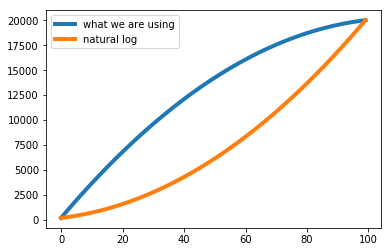

In [2]:
# demo the non-linear sampling of frequencies
plt.plot(expspace(200, 20000, 100, 'flip'), label='what we are using', lw=4)
plt.plot(expspace(200, 20000, 100, 'natural'), label='natural log', lw=4)
plt.legend()

In [6]:
import time
import pydsm  # for the adjustment between perceived amplitude and frequency
from scipy.io.wavfile import write

# params
fs=44100  # sample freq
duration=0.8
tone_length = 0.3  # desired length in seconds

# test this freq range
min_freq = 200
max_freq = 20000
n_freqs = ((max_freq - min_freq)*2)+1
n_freqs = 10
freqs = expspace(min_freq, max_freq, n_freqs, 'flip')

# (1) amplitude task

### for this, we use b-weighting to adjust the perceptual volume across frequencies
### the task will be for people to say whether or not a tone was present, so we can map their auditory acuity
### we will test 10 frequencies (200-20,000Hz), 5 amplitudes, with 4 repetitions

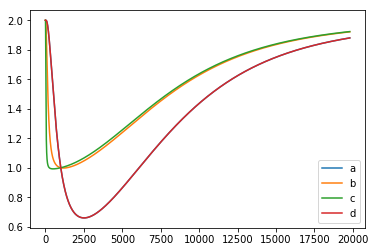

In [255]:
# which method of correcting for perceptual amplitude?
freqs = expspace(200, 20000, 18001, 'flip')

base_amp = pydsm.audio_weightings.a_weighting(freqs)
plt.plot(freqs, (1-base_amp)+1, label='a')
base_amp = pydsm.audio_weightings.b_weighting(freqs)
plt.plot(freqs, (1-base_amp)+1, label='b')
base_amp = pydsm.audio_weightings.c_weighting(freqs)
plt.plot(freqs, (1-base_amp)+1, label='c')
base_amp = pydsm.audio_weightings.a_weighting(freqs)
plt.plot(freqs, (1-base_amp)+1, label='d')
plt.legend()
plt.show()

In [305]:
base_dir = '/Users/lauragwilliams/Documents/experiments/shepard/shepard/pretests/amplitude'

# we should test different amplitudes depending on the freq. we weight
# the amplitude based on standard 
base_amp = pydsm.audio_weightings.b_weighting(freqs)
amp_corrections = (1-base_amp)+1

# test this amp range
min_amp = 0
max_amp = 0.2
n_amps = 5

# make tones, looping through each paramtere
for amp_cor, freq in zip(amp_corrections, freqs):
    for amps in np.linspace(min_amp, max_amp, n_amps):

        # make tone
        tone = complex_tone([freq], [amps*amp_cor], duration)
        play_sound(tone[100:int(fs*tone_length)+100])

        # save to disk
        fname = '%s/%s-%s.wav' % (base_dir, np.round(freq), np.round(amps, 3))
        write(fname, fs, tone[0:int(fs*tone_length)])


# (2) Pitch
### here, we will also to a 2AFC, presenting ptps with different tones, and asking if the pitch is the same or different
### we will use all semitones, and contrast them with the same, and up to one semitone away, in 25 cent increments
### we use this table to get the semitone frequencies: https://pages.mtu.edu/~suits/notefreqs.html

In [8]:
base_dir = '/Users/lauragwilliams/Documents/experiments/shepard/shepard/pretests/pitch'

semitones = np.array([659, 624, 587, 554, 524, 494, 466, 440, 415, 392, 370, 349, 330, 311, 294, 277, 262, 247, 233, 220, 208])
plus_minus = np.linspace(0, 10, 5)  # spacing between tones

duration = 0.8
amp = 5

# loop through each semitone
for ii in range(len(semitones)):
    
    # loop intil one minus the end
    if ii != len(semitones)-1:
        # pull out relevant tones
        tone_0 = semitones[ii]
        tone_1 = semitones[ii+1]

        # get thirds differnce in freq between the tones
        freq_diff = (tone_0 - tone_1)/4.

        # make tone at this pitch
        for jj in range(4):
            adjustment = freq_diff*jj
            this_tone = tone_0 - adjustment
            adjusted_tone1 = complex_tone([this_tone], [duration], amp)

            # save to disk
            fname = '%s/%s-%s.wav' % (base_dir, np.round(this_tone), jj)
            write(fname, fs, adjusted_tone1[0:int(fs*tone_length)])
    
    else:
            this_tone = semitones[-1]
            adjusted_tone1 = complex_tone([this_tone], [duration], amp)

            # save to disk
            fname = '%s/%s-%s.wav' % (base_dir, np.round(this_tone), 0)
            write(fname, fs, adjusted_tone1[0:int(fs*tone_length)])   

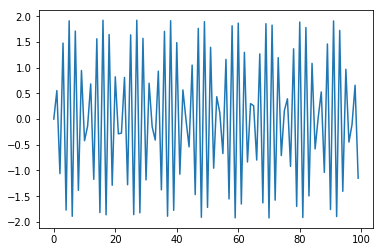

In [303]:
plt.plot(tone[0:int(fs*tone_length)][0:100])